# 06 - 分组与虚拟变量回归


## 分组数据回归

并非所有数据点生而平等。再次审视我们的 ENEM 数据集时，相较于小型学校的成绩，我们更信任大规模学校的成绩。这并非意味着大型学校更优越，而是因其规模庞大意味着方差更小。

```{dropdown} 查看 Stata 代码
```stata
* Load data (assuming CSV is in current directory)
import delimited "/Users/xuwenli/Library/CloudStorage/OneDrive-个人/DSGE建模及软件编程/教学大纲与讲稿/应用计量经济学讲稿/python-causality-handbook/causal-inference-for-the-brave-and-true/data/enem_scores.csv", clear

* Create basic scatterplot	   
* Find max values
sum number_of_students, meanonly
local max_students = r(max)
sum avg_score, meanonly
local max_score = r(max)

twoway (scatter avg_score number_of_students) ///
       (scatter avg_score number_of_students if number_of_students == `max_students', ///
           mlabel(school_id) mlabcolor(black)) ///
       (scatter avg_score number_of_students if avg_score == `max_score', ///
           mlabel(school_id) mlabcolor(black)), ///
       title("ENEM Score by Number of Students") ///
       legend(off)

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

style.use("fivethirtyeight")

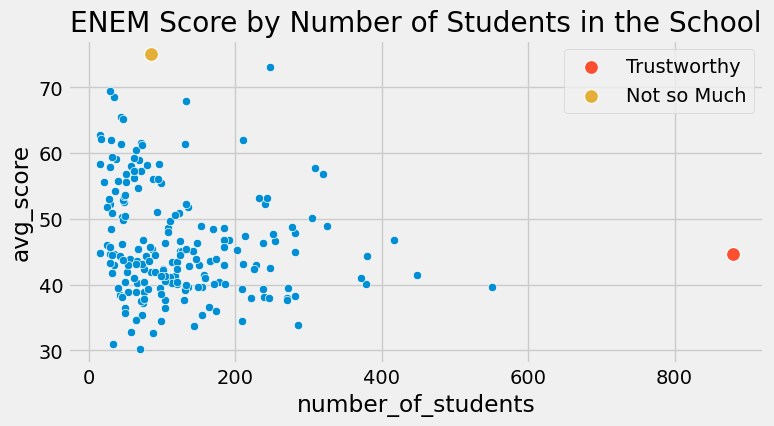

In [4]:
np.random.seed(876)
enem = pd.read_csv("./data/enem_scores.csv").sample(200)
plt.figure(figsize=(8,4))
sns.scatterplot(y="avg_score", x="number_of_students", data=enem)
sns.scatterplot(y="avg_score", x="number_of_students", s=100, label="Trustworthy",
                data=enem.query(f"number_of_students=={enem.number_of_students.max()}"))
sns.scatterplot(y="avg_score", x="number_of_students", s=100, label="Not so Much",
                data=enem.query(f"avg_score=={enem.avg_score.max()}"))
plt.title("ENEM Score by Number of Students in the School");

在上述数据中，直观上，左侧的点对模型的影响应小于右侧的点。本质上，右侧的点实际上是众多其他数据点聚合而成的单一数据点。若能将其解构并对未分组数据执行线性回归，它们对模型估计的贡献确实会远超左侧单独解构的点。

这种现象，即存在一个低方差区域与另一个高方差区域并存的情况，被称为**异方差性**。简而言之，异方差性是指特征值在不同取值上方差不恒定的现象。在上述例子中，我们可以看到随着特征样本量的增加，方差逐渐减小。再举一个存在异方差的例子：若绘制工资随年龄变化的图表，会发现年长者的工资方差明显高于年轻群体。然而，迄今为止，导致方差差异最常见的原因仍是分组数据。

类似上述的分组数据在数据分析中极为常见。其中一个原因是保密性要求。政府和企业无法公开个人数据，否则将违反其必须遵守的数据隐私法规。当需要向外部研究人员提供数据时，他们只能通过分组方式导出数据。这种方法使得个体被归入群体之中，从而无法单独识别具体身份。

幸运的是，回归分析能很好地处理这类数据。为了理解其原理，我们首先以未分组的数据为例，比如之前提到的工资与教育年限数据。该数据集每位工人对应一行记录，因此我们不仅知道其中每个人的工资，还了解其受教育年限。

```{dropdown} 查看 Stata 代码
```stata
* Load data (assuming CSV is in current directory)
import delimited "./data/wage.csv", clear	   
	   
list in 1/5	  

In [7]:
wage = pd.read_csv("./data/wage.csv")[["wage", "lhwage", "educ", "IQ"]]

wage.head()

wage    lhwage  educ   IQ
0   769  2.956212    12   93
1   808  2.782539    18  119
2   825  3.026504    14  108
3   650  2.788093    12   96
4   562  2.642622    11   74

当我们运行回归模型来探究教育年限与小时工资对数之间的关联时，得到了以下结果。

```{dropdown} 查看 Stata 代码
```stata
* Run regression and store results
regress lhwage educ
eststo model1

* Export publication-ready table (English output)
esttab model1 using "wage_regression.rtf", ///
    replace ///
    b(3) se(3) ///
    star(* 0.05 ** 0.01 *** 0.001) ///
    stats(N r2_a, fmt(0 3) labels("Observations" "Adj. R-squared")) ///
    title("Returns to Schooling: Wage Regression Results") ///
    label ///
    varwidth(20) ///
    addnotes("*** p<0.001, ** p<0.01, * p<0.05") ///
    nogaps

* Simplified console output
esttab model1, cells("b(fmt(3) star)") ///
    star(* 0.05 ** 0.01 *** 0.001) ///
    stats(N r2_a, fmt(0 3)) ///
    mtitle("Model (1)") ///
    noomitted


In [11]:
model_1 = smf.ols('lhwage ~ educ', data=wage).fit()
model_1.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

现在，假设这些数据受到保密条款限制。数据提供方无法给出个体层面的信息。于是我们要求其按教育年限分组，仅提供每组的平均小时工资对数及组内人数。这样我们最终只得到 10 个数据点。

```{dropdown} 查看 Stata 代码
```stata
* Alternative using tabstat
tabstat lhwage, by(educ) stat(mean count) nototal	

In [14]:
group_wage = (wage
              .assign(count=1)
              .groupby("educ")
              .agg({"lhwage":"mean", "count":"count"})
              .reset_index())

group_wage

educ    lhwage  count
0     9  2.856475     10
1    10  2.786911     35
2    11  2.855997     43
3    12  2.922168    393
4    13  3.021182     85
5    14  3.042352     77
6    15  3.090766     45
7    16  3.176184    150
8    17  3.246566     40
9    18  3.144257     57

别担心！回归分析并不依赖大数据也能发挥作用！我们可以为线性回归模型赋予权重，这样它会更重视样本量较大的组别，而非小样本组。注意我已将 `smf.ols` 替换为 `smf.wls` ，以实现加权最小二乘法。这一改动虽不易察觉，却将带来显著差异。

```{dropdown} 查看 Stata 代码
```stata
* Correct way to collapse with counts
preserve
    * First create an ID variable for counting
    gen id = 1
    
    * Then collapse
    collapse (mean) lhwage (sum) count=id, by(educ)
    
    * Now run WLS regression
    regress lhwage educ [aweight=count]
    eststo model2
    * Display results
    esttab model2, cells("b(star fmt(3))") ///
        stats(N r2_a, labels("N" "Adj. R2"))
restore	
	
* Display both models
esttab model1 model2, ///
    mtitle("OLS" "WLS") ///
    stats(N r2_a, fmt(0 3))	   

In [17]:
model_2 = smf.wls('lhwage ~ educ', data=group_wage, weights=group_wage["count"]).fit()
model_2.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

请注意分组模型中 `educ` 的参数估计值与未分组数据中的结果极为接近（本例中两者实际完全相同）。即便仅有 10 个数据点，我们仍成功获得了统计显著的系数。这是因为虽然数据点减少，但分组大幅降低了方差。同时注意标准误略小、t 统计量略大的现象——这是由于部分方差信息丢失，我们需要采取更保守的估计。数据分组后，我们无法获知组内方差的具体大小。请将上述结果与下方非加权模型的结果进行对比。

```{dropdown} 查看 Stata 代码
```stata
* First create the grouped data
preserve
    gen id = 1
    collapse (mean) lhwage (sum) count=id, by(educ)
    
    * Run OLS on group means (unweighted)
    regress lhwage educ
    
    * Display formatted results
    eststo model3
    esttab model3, cells("b(star fmt(3))") ///
        stats(N r2, labels("Groups" "R-squared")) ///
        title("OLS on Group Means") ///
        varwidth(15)
restore	 


esttab model1 model2 model3, ///
    mtitle("Original OLS" "WLS" "Grouped OLS") ///
    stats(N r2, fmt(0 3))  

In [20]:
model_3 = smf.ols('lhwage ~ educ', data=group_wage).fit()
model_3.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

参数估计值较小。此处的情况是，回归分析对所有数据点赋予同等权重。若将模型与分组点一同绘制，可见未加权模型过度重视了左下角的小点群，导致拟合直线的斜率偏低。

```{dropdown} 查看 Stata 代码
```stata
* Create grouped data if not already done
preserve
    gen id = 1
    collapse (mean) lhwage (sum) count=id, by(educ)
    
    * Run both regressions
    regress lhwage educ [aweight=count]  // Weighted
    predict weighted_pred
    regress lhwage educ                  // Unweighted
    predict unweighted_pred
    
    * Create the plot
    twoway (scatter lhwage educ [weight=count], ///
               msymbol(Oh) msize(*.5) mcolor(blue)) ///
           (line weighted_pred educ, lcolor(orange) lwidth(medthick)) ///
           (line unweighted_pred educ, lcolor(green) lwidth(medthick)), ///
           title("Log Wage by Education") ///
           xtitle("Years of Education") ///
           ytitle("Log Hourly Wage") ///
           legend(order(2 "Weighted" 3 "Non Weighted") pos(6) row(1)) ///
           graphregion(color(white)) ///
           plotregion(color(white)) ///
           xlabel(8(2)20) ///
           ylabel(, angle(horizontal))
restore	   

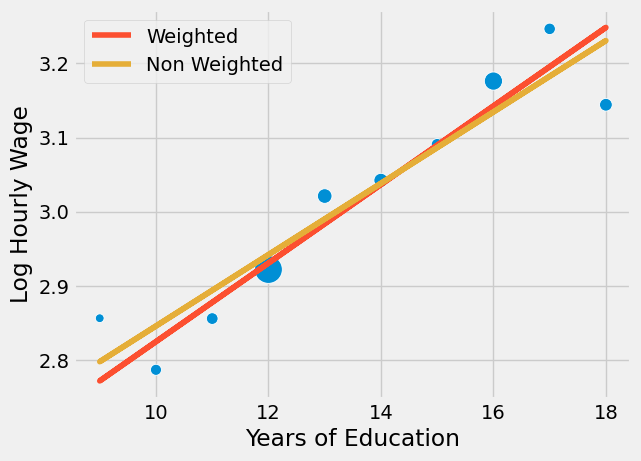

In [23]:
sns.scatterplot(x="educ", y = "lhwage", size="count", legend=False, data=group_wage, sizes=(40, 400))
plt.plot(wage["educ"], model_2.predict(wage["educ"]), c="C1", label = "Weighted")
plt.plot(wage["educ"], model_3.predict(wage["educ"]), c="C2", label = "Non Weighted")
plt.xlabel("Years of Education")
plt.ylabel("Log Hourly Wage")
plt.legend();

关键在于回归分析这一卓越工具既适用于个体数据也适用于聚合数据，但在后者情况下必须使用加权处理。加权回归需要均值统计量——既非总和，也非标准差或中位数，而是协变量与因变量的均值！需注意，分组数据的加权回归结果虽不会与未分组数据的回归完全一致，但会非常接近。

![img](./images/06/heterosk.png)

我将以一个在分组数据模型中引入额外协变量的最终示例作为结束。

```{dropdown} 查看 Stata 代码
```stata
* Create grouped data with means and counts
preserve
    gen count = 1
    collapse (mean) lhwage iq (sum) count, by(educ)
    
    * Run WLS regression
    regress lhwage educ iq [aweight=count]
    
    * Display results
    estimates store model4
    display "Number of observations: " e(N)
    esttab model4, cells("b(star fmt(3))") ///
        stats(N r2_a, labels("Observations" "Adj. R-squared")) ///
        title("WLS Results with IQ") ///
        varwidth(20)
restore	   
	   
esttab model1 model2 model3 model4, ///
    mtitle("Original OLS" "WLS" "Grouped OLS" "With Covariate") ///
    stats(N r2, fmt(0 3))	   

In [26]:
group_wage = (wage
              .assign(count=1)
              .groupby("educ")
              .agg({"lhwage":"mean", "IQ":"mean", "count":"count"})
              .reset_index())

model_4 = smf.wls('lhwage ~ educ + IQ', data=group_wage, weights=group_wage["count"]).fit()
print("Number of observations:", model_4.nobs)
model_4.summary().tables[1]

Number of observations: 10.0


<class 'statsmodels.iolib.table.SimpleTable'>

在此例中，除了先前加入的教育年限外，我们还把智商作为特征纳入。操作机制大体相同：获取均值与计数，以均值为回归目标，并将计数作为权重。

## 虚拟变量回归入门

虚拟变量是经过二进制列编码的分类变量。例如，假设你有一个希望纳入模型的性别变量，该变量被编码为三类：男性、女性及其他性别。

|gender（性别）|
|------|
|male  |
|female|
|female|
|other |
|male  |

由于我们的模型仅接受数值输入，需将此分类转换为数字。在线性回归中，我们采用虚拟变量实现这一转换。具体做法是将每个变量编码为 0/1 列，表示该分类是否存在。同时，我们会省略其中一个分类作为基准类别。这是因为最后一个类别实际上是其他类别的线性组合。换言之，若已知其他类别的信息，即可推导出最后一个类别。以本例而言，若某人既非女性也非其他性别，则可推断其分类为男性。

|gender（性别）|female|other|
|------|:-----|:----|
|male  |0|0|
|female|1|0|
|female|1|0|
|other |0|1|
|male  |0|0|

在讨论 A/B 测试时，我们已经处理过虚拟回归的一种简单形式。更一般地说，当我们处理二元处理变量时，会将其表示为虚拟变量。这种情况下，**该虚拟变量的回归系数即为回归线截距的增量**，或者说处理组与未处理组均值之差。

为了更具体地说明这一点，让我们考虑一个估计完成 12 年级教育对时薪影响的例子（暂且忽略混杂因素）。在下面的代码中，我们创建了一个处理虚拟变量 `T` ，用于指示受教育年限是否超过 12 年。

```{dropdown} 查看 Stata 代码
```stata
* Create hourly wage (wage divided by hours)
gen hwage = wage / hours

* Create treatment indicator (education > 12 years)
gen T = (educ > 12) if !missing(educ)

* Label variables
label variable hwage "Hourly wage"
label variable T "Higher education (educ > 12)"

* Display first 5 observations of selected variables
list hwage iq T in 1/5, noobs clean	   

In [32]:
wage = (pd.read_csv("./data/wage.csv")
        .assign(hwage=lambda d: d["wage"] / d["hours"])
        .assign(T=lambda d: (d["educ"] > 12).astype(int)))

wage[["hwage", "IQ", "T"]].head()

hwage   IQ  T
0  19.225   93  0
1  16.160  119  1
2  20.625  108  1
3  16.250   96  0
4  14.050   74  0

该虚拟变量起到一种开关的作用。在我们的例子中，如果虚拟变量开启，预测值就是截距加上虚拟变量的系数；如果关闭，预测值则仅为截距。

```{dropdown} 查看 Stata 代码
```stata
* Run OLS regression of hourly wage on treatment indicator
regress hwage T

* Display formatted coefficient table
eststo model5

* Alternative using esttab for publication-quality output
esttab model5, cells("b(star fmt(3))") ///
    stats(N r2_a, labels("Observations" "Adj. R-squared")) ///
    title("Treatment Effect of Higher Education on Hourly Wage") ///
    varwidth(20)	

In [35]:
smf.ols('hwage ~ T', data=wage).fit().summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

在此案例中，当个体未完成 12 年级学业（虚拟变量关闭）时，其平均收入为 19.9。若完成 12 年级学业（虚拟变量开启），预测值即平均收入则为 24.8449（19.9405 + 4.9044）。因此，虚拟变量的系数捕捉了均值差异，本例中该差异值为 4.9044。

更正式地说，当自变量为二分变量时（如处理指标常见的情形），回归能完美捕捉平均处理效应（ATE）。这是因为回归是对条件期望函数（CEF）$E[Y|X]$ 的线性近似，而在此特定情境下，CEF 本身就是线性的。具体而言，我们可以定义 $E[Y_i|T_i=0]=\alpha$ 和 $E[Y_i|T_i=1] = \alpha + \beta$，从而导出如下 CEF 表达式

$
E[Y_i|T_i] =  E[Y_i|T_i=0] + \beta T_i = \alpha + \beta T_i
$

而 $\beta$ 在随机数据情形下即为均值差异或平均处理效应（ATE）

$
\beta = [Y_i|T_i=1] - [Y_i|T_i=0]
$

若引入额外变量，虚拟变量的系数即转化为**条件均值差**。例如，假设我们在原有模型中添加智商（IQ）这一变量。此时，虚拟系数表示在**智商固定**的情况下，完成 12 年级学业预期带来的增长幅度。若绘制预测图，我们将看到两条平行线。从一条线跃升至另一条线的高度，即为完成 12 年级学业所预期的提升量。这也说明效应具有恒定性——无论智商高低，完成 12 年级学业对所有人的益处均等。

```{dropdown} 查看 Stata 代码
```stata
* Run OLS regression with treatment and IQ
regress hwage T iq

* Store fitted values
predict y_hat, xb

* Create separate prediction lines
twoway (line y_hat iq if T == 1, lcolor(orange) lwidth(medthick)) ///
       (line y_hat iq if T == 0, lcolor(green) lwidth(medthick)), ///
       title("Treatment Effect Conditional on IQ") ///
       subtitle("E[T=1|IQ] - E[T=0|IQ] = " + string(_b[T], "%4.2f")) ///
       ytitle("Predicted Hourly Wage") ///
       xtitle("IQ Score") ///
       legend(order(1 "T=1 (educ >12)" 2 "T=0 (educ ≤12)")) ///
       graphregion(color(white)) ///
       plotregion(color(white))	   

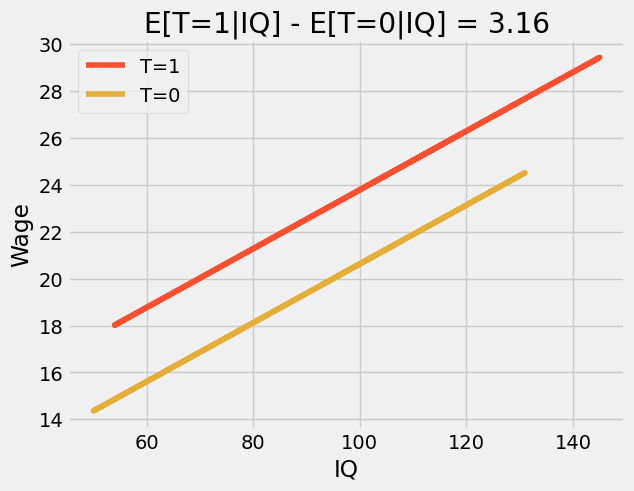

In [38]:
m = smf.ols('hwage ~ T+IQ', data=wage).fit()
plt_df = wage.assign(y_hat = m.fittedvalues)

plt.plot(plt_df.query("T==1")["IQ"], plt_df.query("T==1")["y_hat"], c="C1", label="T=1")
plt.plot(plt_df.query("T==0")["IQ"], plt_df.query("T==0")["y_hat"], c="C2", label="T=0")
plt.title(f"E[T=1|IQ] - E[T=0|IQ] = {round(m.params['T'], 2)}")
plt.ylabel("Wage")
plt.xlabel("IQ")
plt.legend();

若将此模型转化为方程，原因便显而易见：

$
wage_i = \beta_0 + \beta_1T_i + \beta_2 IQ_i + e_i
$

此处， $\beta_1$ 代表条件均值差，在我们的案例中它是一个恒定值 3.16。通过添加交互项，我们可以使该模型更具灵活性。

$
wage_i = \beta_0 + \beta_1T_i + \beta_2 IQ_i + \beta_3 IQ_i * T_i  + e_i
$

情况变得稍微复杂一些，让我们看看这个模型中每个参数的含义。首先是截距 $\beta_0$。这个参数本身并没有特别有趣的解释，它表示当处理变量为零（即个人未完成 12 年级教育）且智商为零时的预期工资。由于我们预期任何人的智商都不会为零，因此这一参数的意义不大。至于 $\beta_1$，情况类似。该参数表示在**智商为零**时，完成 12 年级教育对工资的预期增加量。同样，因为智商不可能为零，所以这一参数也没有特别的实际意义。现在来看 $\beta_2$ ，它稍微有趣一些。它告诉我们对于**未接受处理**的群体，智商每增加一点对工资的影响。在我们的例子中，这个值大约是 0.11，意味着每增加 1 个智商点，未完成 12 年级教育的人每小时工资预计会增加 11 美分。最后，最有趣的参数是 $\beta_3$。它揭示了智商如何放大完成 12 年级教育的效果。在我们的案例中，该参数为 0.024，表示每增加 1 个智商点，完成 12 年级教育能额外带来 2 美分的工资增长。 这看起来或许不多，但比较一下智商 60 和 140 的人。前者工资将增加 1.44（60 乘以 0.024），而智商 140 的人在完成 12 年级学业时，收入将额外增加 3.36 美元（140 乘以 0.024）。

用简单的建模术语来说，这一交互项允许处理效应随特征水平（本例中仅为智商）而变化。结果是，如果我们绘制预测线，会发现它们不再平行，且那些完成 12 年级学业（T=1）的个体在智商维度上具有更高的斜率——高智商者比低智商者从毕业中获益更多。这种现象有时被称为效应修饰或异质性处理效应。

```{dropdown} 查看 Stata 代码
```stata
* 1. Run regression with interaction term
regress hwage c.T##c.iq

* 2. Store coefficients for dynamic title
scalar T_effect = _b[T]
scalar IQ_effect = _b[iq]
scalar interaction = _b[T#c.iq]

* 3. Generate predicted values
predict y_hat1, xb

* 4. Create plot with interaction lines
twoway (line y_hat1 iq if T == 1, lcolor(orange) lwidth(medthick)) ///
       (line y_hat1 iq if T == 0, lcolor(green) lwidth(medthick)), ///
       title("Treatment Effect with IQ Interaction") ///
       ytitle("Predicted Hourly Wage") ///
       xtitle("IQ Score") ///
       legend(order(1 "T=1 (educ >12)" 2 "T=0 (educ ≤12)")) ///
       graphregion(color(white)) ///
       plotregion(color(white))	   

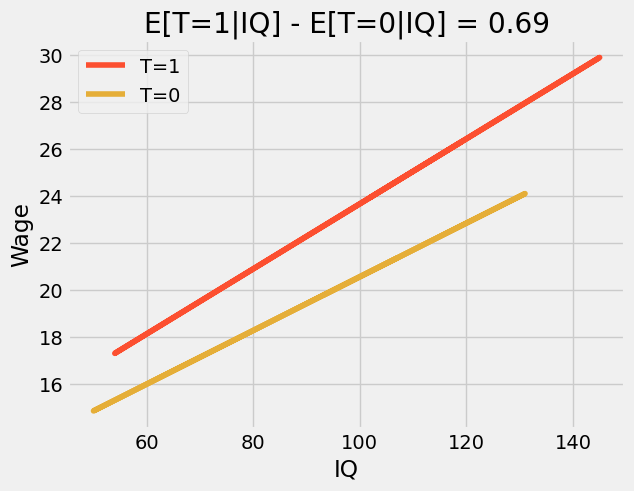

In [41]:
m = smf.ols('hwage ~ T*IQ', data=wage).fit()
plt_df = wage.assign(y_hat = m.fittedvalues)

plt.plot(plt_df.query("T==1")["IQ"], plt_df.query("T==1")["y_hat"], c="C1", label="T=1")
plt.plot(plt_df.query("T==0")["IQ"], plt_df.query("T==0")["y_hat"], c="C2", label="T=0")
plt.title(f"E[T=1|IQ] - E[T=0|IQ] = {round(m.params['T'], 2)}")
plt.ylabel("Wage")
plt.xlabel("IQ")
plt.legend();

最后，我们来看模型中所有变量均为虚拟变量的情况。为此，我们将智商（IQ）离散化为 4 个区间，并将受教育年限视为类别变量。

```{dropdown} 查看 Stata 代码
```stata
* Create IQ quartile bins (4 equal-sized groups)
xtile iq_bins = iq, nq(4)

* Label the bins for clarity
label define iq_bins 1 "Q1 (Lowest)" 2 "Q2" 3 "Q3" 4 "Q4 (Highest)"
label values iq_bins iq_bins

* Keep only needed variables
keep hwage educ iq_bins

* Display first 5 observations
list in 1/5, noobs clean

In [44]:
wage_ed_bins = (wage
                .assign(IQ_bins = lambda d: pd.qcut(d["IQ"], q=4, labels=range(4)))
                [["hwage", "educ", "IQ_bins"]])

wage_ed_bins.head()

hwage  educ IQ_bins
0  19.225    12       1
1  16.160    18       3
2  20.625    14       2
3  16.250    12       1
4  14.050    11       0

将教育视为类别变量后，我们不再将教育的影响限制于单一参数，而是允许每一年的教育都有其独特的影响。这样做增加了模型的灵活性，因为教育效应不再受参数化约束。该模型仅计算每一年教育对应的平均工资。

```{dropdown} 查看 Stata 代码
```stata
* Run regression with education category dummies
regress hwage i.educ

* Display formatted coefficient table
eststo model6

* Alternative using esttab for publication-quality output
esttab model6, cells("b(star fmt(3))") ///
    stats(N r2_a, labels("Observations" "Adj. R-squared")) ///
    title("Hourly Wage by Education Level") ///
    varwidth(20)
	
	
predict y_hat2, xb

In [47]:
model_dummy = smf.ols('hwage ~ C(educ)', data=wage).fit()
model_dummy.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

```{dropdown} 查看 Stata 代码
```stata
* Create scatterplot with regression line
twoway (scatter hwage educ, mcolor(blue%50) msymbol(Oh)) ///
       (line y_hat2 educ, sort lcolor(orange) lwidth(medthick)), ///
       title("Hourly Wage by Education") ///
       xtitle("Years of Education") ///
       ytitle("Hourly Wage") ///
       legend(off) ///
       graphregion(color(white)) ///
       plotregion(color(white)) ///
       xlabel(8(2)20)

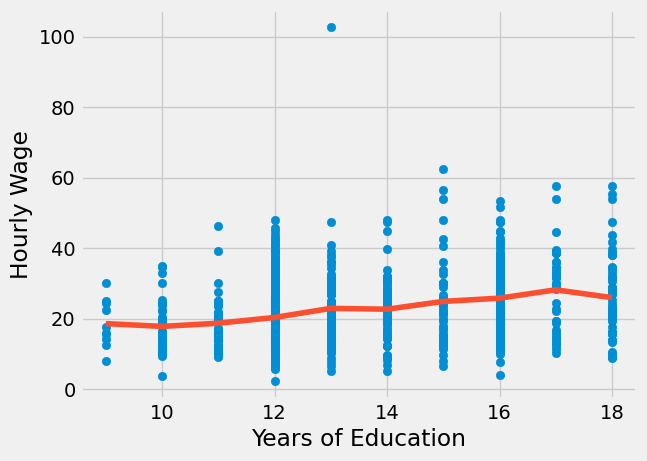

In [49]:
plt.scatter(wage["educ"], wage["hwage"])
plt.plot(wage["educ"].sort_values(), model_dummy.predict(wage["educ"].sort_values()), c="C1")
plt.xlabel("Years of Education")
plt.ylabel("Hourly Wage");

首先，注意到这种方法消除了关于教育如何影响工资的函数形式的任何假设。我们不再需要担心对数转换。本质上，这个模型是完全非参数的。它所做的只是计算每一年教育年限对应的工资样本均值。这可以从上图中看出，拟合线并不具有特定形式，而是对每一年教育年限样本均值的插值。我们还可以通过重构一个参数来验证这一点，例如 17 年教育年限的参数。对于此模型，该参数值为 `9.5905` 。下方可见，它仅是基准教育年限（9 年）与拥有 17 年教育年限个体之间的差异。

$
\beta_{17} = E[Y|T=17]-E[Y|T=9]
$

代价是当我们允许如此大的灵活性时，会丧失统计显著性。注意某些年份的 p 值有多大。

```{dropdown} 查看 Stata 代码
```stata
* Calculate means for educ==9 and educ==17
sum hwage if educ == 9
scalar t0_mean = r(mean)
display "E[Y|T=9]: " %5.2f t0_mean

sum hwage if educ == 17
scalar t1_mean = r(mean)
scalar diff = t1_mean - t0_mean
display "E[Y|T=17]-E[Y|T=9]: " %5.2f diff

In [52]:
t1 = wage.query("educ==17")["hwage"]
t0 = wage.query("educ==9")["hwage"]
print("E[Y|T=9]:", t0.mean())
print("E[Y|T=17]-E[Y|T=9]:", t1.mean() - t0.mean())

E[Y|T=9]: 18.56
E[Y|T=17]-E[Y|T=9]: 9.590472362353516


若在模型中纳入更多虚拟协变量，教育参数的估计值将转化为各虚拟组别效应的加权平均值：

$
E\{ \ (E[Y_i|T=1, Group_i] - E[Y_i|T=0, Group_i])w(Group_i) \ \}
$

$w(Group_i)$ 并不完全等同于组 $Var(T_i|Group_i)$ 中处理变量的方差，而是与之成比例。由此自然产生的一个问题是：为什么不使用完全非参数估计量，其中组的权重就是样本量？这确实是一个有效的估计量，但回归分析并不采用这种方法。通过利用处理变量的方差，回归分析赋予处理变量变化较大的组更多权重。这在直觉上是有道理的。如果处理变量几乎恒定（例如只有一人接受处理而其他人都未处理），那么无论样本量多大，该组提供的信息对于处理效应的了解都极为有限。

```{dropdown} 查看 Stata 代码
```stata
* Run regression with both sets of dummies
regress hwage i.educ i.iq_bins

* Store results and display formatted table
eststo model_dummy2
esttab model_dummy2, cells("b(star fmt(3))") ///
    stats(N r2_a, labels("Observations" "Adj. R-squared")) ///
    title("Wage Regression with Education and IQ Dummies") ///
    varwidth(25)	   

In [55]:
model_dummy_2 = smf.ols('hwage ~ C(educ) + C(IQ_bins)', data=wage_ed_bins).fit()
model_dummy_2.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

![img](./images/06/you_little_shit.png)

## 核心要点

本节开篇，我们探讨了为何某些数据点比其他数据点更为关键。具体而言，在估计线性模型时，样本量更大、方差更小的数据点应被赋予更高权重。随后，我们研究了线性回归如何巧妙处理分组匿名数据，前提是在模型中运用样本权重。

接着，我们转向虚拟变量回归。了解到通过将其构建为非参数模型，可完全不对处理效应与结果之间的函数形式做任何假设。之后，我们深入剖析了虚拟变量回归背后的直观逻辑。




## 参考文献
我愿将这一系列作品视为对 Joshua Angrist、Alberto Abadie 和 Christopher Walters 杰出计量经济学课程的致敬。第一部分的大部分思想源自他们在美国经济学会授课的内容。在艰难的 2020 年，正是观看他们的课程视频让我保持了理智。

 - [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
 - [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

 我还想引用 Angrist 的精彩著作。它们向我展示了计量经济学（他们称之为“Metrics”）不仅极为实用，而且充满乐趣。
 - [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com)
 - [Mastering ‘Metrics](https://www.masteringmetrics.com)

最后还要感谢 Miguel Hernán 和 Jamie Robins 的[《Causal Inference》](https://hsph.harvard.edu/profile/miguel-hernan/)一书。它是我在面对最棘手的因果问题时的可靠伙伴。

![img](./images/poetry.png)

## 参与贡献

**《Causal Inference for the Brave and True》** 是一本关于因果推断的开源教材，致力于以经济上可负担、认知上可理解的方式，普及这门“科学的统计基础”。全书基于 Python，仅使用自由开源软件编写，原始英文版本由 [Matheus Facure](https://github.com/matheusfacure) 编写与维护。

本书的中文版由黄文喆与许文立助理教授合作翻译，并托管在 [GitHub 中文主页](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。希望本地化的内容能帮助更多中文读者学习和掌握因果推断方法。

如果你觉得这本书对你有帮助，并希望支持该项目，可以前往 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true) 支持原作者。

如果你暂时不方便进行经济支持，也可以通过以下方式参与贡献：

* 修正错别字
* 提出翻译或表达建议
* 反馈你未能理解的部分内容

欢迎前往英文版或中文版仓库点击 [issues 区](https://github.com/matheusfacure/python-causality-handbook/issues) 或 [中文版 issues 区](https://github.com/Wenzhe-Huang/python-causality-handbook-zh/issues) 提出反馈。

最后，如果你喜欢这本书的内容，也请将其分享给可能感兴趣的朋友，并为项目在 GitHub 上点亮一颗星：[英文版仓库](https://github.com/matheusfacure/python-causality-handbook) / [中文版仓库](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。